# Critical Path Analysis in Multi-Layer Pub-Sub Systems

## Comprehensive Approach: Components + Paths

This notebook demonstrates advanced analysis that identifies:

### **Critical Components**
- Individual nodes with high structural/business criticality
- Articulation points (single points of failure)
- High-impact components

### **Critical Paths** (NEW)
1. **Message Flow Paths**: Publisher → Topic → Subscriber chains
2. **Dependency Chains**: Application dependency sequences
3. **Infrastructure Paths**: Node connectivity paths
4. **Cross-Layer Paths**: End-to-end system paths
5. **Bottleneck Paths**: Paths through articulation points
6. **Single-Point Paths**: Paths with no redundancy

---

## Why Path Analysis Matters

- **Cascading Failures**: A single failure can propagate along paths
- **Dependency Chains**: Long chains create vulnerability
- **Redundancy Assessment**: Identifies paths with no alternatives
- **Impact Prediction**: Shows how failures spread through the system
- **Optimization**: Reveals where to add redundancy

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import defaultdict
from typing import Dict, List, Set, Tuple
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

print("✓ Environment ready for critical path analysis")

✓ Environment ready for critical path analysis


## 1. Create Realistic Multi-Layer System

In [2]:
def create_complex_pubsub_system() -> nx.DiGraph:
    """
    Create a realistic pub-sub system with multiple layers and paths
    """
    G = nx.DiGraph()
    
    # Layer 1: Physical Infrastructure (5 nodes)
    nodes = ['Node1', 'Node2', 'Node3', 'Node4', 'Node5']
    for node in nodes:
        G.add_node(node, type='Node', name=node)
    
    # Node connectivity (mesh topology)
    connections = [
        ('Node1', 'Node2'), ('Node2', 'Node3'), ('Node3', 'Node4'),
        ('Node1', 'Node3'), ('Node2', 'Node4'), ('Node4', 'Node5'),
        ('Node1', 'Node5')  # Some redundancy
    ]
    for src, tgt in connections:
        G.add_edge(src, tgt, type='CONNECTS_TO')
        G.add_edge(tgt, src, type='CONNECTS_TO')
    
    # Layer 2: Brokers
    brokers = [('MainBroker', 'Node1'), ('BackupBroker', 'Node3')]
    for broker, node in brokers:
        G.add_node(broker, type='Broker', name=broker)
        G.add_edge(broker, node, type='RUNS_ON')
    
    # Layer 3: Topics (with QoS)
    topics = [
        ('T1', 'orders', 'PERSISTENT', 'RELIABLE', 'MainBroker'),
        ('T2', 'payments', 'PERSISTENT', 'RELIABLE', 'MainBroker'),
        ('T3', 'inventory', 'TRANSIENT', 'RELIABLE', 'MainBroker'),
        ('T4', 'notifications', 'TRANSIENT', 'RELIABLE', 'BackupBroker'),
        ('T5', 'analytics', 'VOLATILE', 'BEST_EFFORT', 'BackupBroker'),
        ('T6', 'logs', 'VOLATILE', 'BEST_EFFORT', 'BackupBroker'),
    ]
    
    for tid, name, dur, rel, broker in topics:
        G.add_node(tid, type='Topic', name=name, durability=dur, reliability=rel)
        G.add_edge(broker, tid, type='ROUTES')
    
    # Layer 4: Applications (creating dependency chains)
    apps = [
        # Core services (create a critical path)
        ('OrderService', 'Node1', ['T1'], ['T2', 'T3']),
        ('PaymentService', 'Node2', ['T2'], ['T1']),
        ('InventoryService', 'Node3', ['T3'], ['T1']),
        
        # Support services (depend on core)
        ('NotificationService', 'Node2', ['T4'], ['T1', 'T2', 'T3']),
        ('ShippingService', 'Node4', [], ['T1', 'T3']),
        
        # Analytics pipeline (separate path)
        ('DataCollector', 'Node4', ['T5'], ['T1', 'T2', 'T3']),
        ('AnalyticsEngine', 'Node5', [], ['T5']),
        
        # Monitoring (low criticality)
        ('LogAggregator', 'Node5', ['T6'], ['T5']),
        ('MetricsCollector', 'Node5', [], ['T6']),
        
        # API Gateway (fan-out pattern)
        ('APIGateway', 'Node1', [], ['T1', 'T2', 'T3', 'T4']),
    ]
    
    for app, node, pubs, subs in apps:
        G.add_node(app, type='Application', name=app)
        G.add_edge(app, node, type='RUNS_ON')
        for t in pubs:
            G.add_edge(app, t, type='PUBLISHES_TO')
        for t in subs:
            G.add_edge(app, t, type='SUBSCRIBES_TO')
    
    # Create DEPENDS_ON relationships
    for app1, _, pubs, _ in apps:
        for topic in pubs:
            for app2, _, _, subs in apps:
                if app1 != app2 and topic in subs:
                    G.add_edge(app2, app1, type='DEPENDS_ON')
    
    return G

G = create_complex_pubsub_system()

print("Multi-Layer System Created:")
print(f"  Total components: {G.number_of_nodes()}")
print(f"  Total relationships: {G.number_of_edges()}")

type_counts = {}
for _, data in G.nodes(data=True):
    t = data['type']
    type_counts[t] = type_counts.get(t, 0) + 1

print("\nComponent Distribution:")
for t, c in sorted(type_counts.items()):
    print(f"  {t}: {c}")

Multi-Layer System Created:
  Total components: 23
  Total relationships: 76

Component Distribution:
  Application: 10
  Broker: 2
  Node: 5
  Topic: 6


## 2. Compute Component Criticality

First, we need component-level criticality scores.

In [3]:
# Compute component criticality (simplified version)

# 1. Topology metrics
betweenness = nx.betweenness_centrality(G, normalized=True)
undirected = G.to_undirected()
articulation_points = set(nx.articulation_points(undirected))

# 2. Topic importance
def get_topic_importance(node_data):
    if node_data.get('type') != 'Topic':
        return 0.5
    
    dur_scores = {'VOLATILE': 0.2, 'TRANSIENT_LOCAL': 0.5, 
                  'TRANSIENT': 0.75, 'PERSISTENT': 1.0}
    rel_scores = {'BEST_EFFORT': 0.3, 'RELIABLE': 1.0}
    
    dur = dur_scores.get(node_data.get('durability', 'VOLATILE'), 0.2)
    rel = rel_scores.get(node_data.get('reliability', 'BEST_EFFORT'), 0.3)
    
    return 0.6 * dur + 0.4 * rel

# Calculate importance for all nodes
importance = {}
for node, data in G.nodes(data=True):
    importance[node] = get_topic_importance(data)

# Propagate to applications
for node, data in G.nodes(data=True):
    if data['type'] == 'Application':
        pubs = [t for _, t, e in G.out_edges(node, data=True) 
                if e['type'] == 'PUBLISHES_TO']
        subs = [t for _, t, e in G.out_edges(node, data=True) 
                if e['type'] == 'SUBSCRIBES_TO']
        
        pub_imp = [importance[t] for t in pubs] if pubs else [0.5]
        sub_imp = [importance[t] for t in subs] if subs else [0.5]
        
        importance[node] = 0.7 * np.mean(pub_imp) + 0.3 * np.mean(sub_imp)

# 3. Composite criticality
criticality = {}
for node in G.nodes():
    base = 0.6 * betweenness[node] + 0.4 * (1.0 if node in articulation_points else 0.0)
    criticality[node] = base * (1 + 0.5 * importance[node])

print("\n" + "="*80)
print("COMPONENT CRITICALITY ANALYSIS")
print("="*80)

crit_df = pd.DataFrame([
    {'name': G.nodes[n]['name'], 'type': G.nodes[n]['type'],
     'criticality': criticality[n], 'is_ap': n in articulation_points}
    for n in G.nodes()
]).sort_values('criticality', ascending=False)

print("\nTop 10 Critical Components:")
print(crit_df.head(10).to_string(index=False))

print(f"\nArticulation Points: {len(articulation_points)}")
if articulation_points:
    ap_names = [G.nodes[n]['name'] for n in articulation_points]
    print(f"  → {', '.join(ap_names)}")


COMPONENT CRITICALITY ANALYSIS

Top 10 Critical Components:
            name        type  criticality  is_ap
   DataCollector Application     0.033450  False
           Node1        Node     0.025054  False
    OrderService Application     0.020301  False
           Node4        Node     0.017857  False
           Node5        Node     0.016829  False
           Node3        Node     0.014448  False
           Node2        Node     0.012554  False
   LogAggregator Application     0.011636  False
InventoryService Application     0.006329  False
  PaymentService Application     0.004286  False

Articulation Points: 0


## 3. Analyze Critical Paths

Now we identify critical paths across all layers.

In [4]:
# Simplified path analyzer implementation

def analyze_message_flow_paths(graph, criticality, importance, aps):
    """Find Publisher → Topic → Subscriber paths"""
    paths = []
    
    # Find publishers and subscribers per topic
    pubs = defaultdict(list)
    subs = defaultdict(list)
    
    for node in graph.nodes():
        if graph.nodes[node]['type'] != 'Application':
            continue
        for _, target, edge_data in graph.out_edges(node, data=True):
            if graph.nodes[target]['type'] == 'Topic':
                if edge_data['type'] == 'PUBLISHES_TO':
                    pubs[target].append(node)
                elif edge_data['type'] == 'SUBSCRIBES_TO':
                    subs[target].append(node)
    
    # Create paths
    for topic in set(pubs.keys()) & set(subs.keys()):
        for pub in pubs[topic]:
            for sub in subs[topic]:
                if pub != sub:
                    path = [pub, topic, sub]
                    crits = [criticality[n] for n in path]
                    paths.append({
                        'path': path,
                        'path_str': ' → '.join([graph.nodes[n]['name'] for n in path]),
                        'length': len(path),
                        'avg_criticality': np.mean(crits),
                        'min_criticality': np.min(crits),
                        'has_ap': any(n in aps for n in path),
                        'type': 'message_flow'
                    })
    
    return sorted(paths, key=lambda x: x['avg_criticality'], reverse=True)

def analyze_dependency_chains(graph, criticality, importance, aps, max_length=6):
    """Find application dependency chains"""
    paths = []
    
    apps = [n for n, d in graph.nodes(data=True) if d['type'] == 'Application']
    
    for source in apps:
        for target in apps:
            if source != target:
                try:
                    # Find dependency paths
                    simple_paths = nx.all_simple_paths(
                        graph, source, target, cutoff=max_length
                    )
                    
                    for path in simple_paths:
                        # Check if all edges are DEPENDS_ON
                        is_dep_chain = all(
                            graph.edges[path[i], path[i+1]].get('type') == 'DEPENDS_ON'
                            for i in range(len(path)-1)
                        )
                        
                        if is_dep_chain and len(path) >= 2:
                            crits = [criticality[n] for n in path]
                            paths.append({
                                'path': path,
                                'path_str': ' → '.join([graph.nodes[n]['name'] for n in path]),
                                'length': len(path),
                                'avg_criticality': np.mean(crits),
                                'min_criticality': np.min(crits),
                                'has_ap': any(n in aps for n in path),
                                'type': 'dependency_chain'
                            })
                except:
                    continue
    
    # Sort by length first, then criticality
    paths.sort(key=lambda x: (x['length'], x['avg_criticality']), reverse=True)
    return paths[:50]  # Top 50

# Analyze paths
print("\n" + "="*80)
print("CRITICAL PATH ANALYSIS")
print("="*80)

print("\nAnalyzing message flow paths...")
message_paths = analyze_message_flow_paths(G, criticality, importance, articulation_points)
print(f"  Found {len(message_paths)} message flow paths")

print("\nAnalyzing dependency chains...")
dependency_paths = analyze_dependency_chains(G, criticality, importance, articulation_points)
print(f"  Found {len(dependency_paths)} dependency chains")

print("\n" + "-"*80)
print("TOP 10 CRITICAL MESSAGE FLOW PATHS")
print("-"*80)
msg_df = pd.DataFrame(message_paths[:10])
if len(msg_df) > 0:
    print(msg_df[['path_str', 'avg_criticality', 'min_criticality', 'has_ap']].to_string(index=False))

print("\n" + "-"*80)
print("LONGEST DEPENDENCY CHAINS")
print("-"*80)
dep_df = pd.DataFrame(dependency_paths[:10])
if len(dep_df) > 0:
    print(dep_df[['path_str', 'length', 'avg_criticality', 'has_ap']].to_string(index=False))


CRITICAL PATH ANALYSIS

Analyzing message flow paths...
  Found 19 message flow paths

Analyzing dependency chains...
  Found 50 dependency chains

--------------------------------------------------------------------------------
TOP 10 CRITICAL MESSAGE FLOW PATHS
--------------------------------------------------------------------------------
                                    path_str  avg_criticality  min_criticality  has_ap
       OrderService → orders → DataCollector         0.017917              0.0   False
   DataCollector → analytics → LogAggregator         0.015029              0.0   False
InventoryService → inventory → DataCollector         0.013260              0.0   False
   PaymentService → payments → DataCollector         0.012579              0.0   False
 DataCollector → analytics → AnalyticsEngine         0.011150              0.0   False
    OrderService → orders → InventoryService         0.008877              0.0   False
 InventoryService → inventory → OrderService 

## 4. Identify Path Vulnerabilities

In [5]:
def identify_bottleneck_paths(paths):
    """Paths through articulation points"""
    return [p for p in paths if p['has_ap']]

def calculate_path_redundancy(graph, path):
    """Calculate if alternative paths exist"""
    if len(path) < 2:
        return 1.0
    
    source, target = path[0], path[-1]
    try:
        all_paths = list(nx.all_simple_paths(graph, source, target, cutoff=len(path)+2))
        num_paths = len(all_paths)
        return min(1.0, (num_paths - 1) / 4.0)
    except:
        return 0.0

# Analyze vulnerabilities
print("\n" + "="*80)
print("PATH VULNERABILITY ANALYSIS")
print("="*80)

all_paths = message_paths + dependency_paths

# Bottleneck paths
bottleneck_paths = identify_bottleneck_paths(all_paths)
print(f"\n1. BOTTLENECK PATHS (through articulation points): {len(bottleneck_paths)}")
if bottleneck_paths:
    print("\nTop 5:")
    for i, p in enumerate(bottleneck_paths[:5], 1):
        print(f"  {i}. {p['path_str']}")
        print(f"     Avg Criticality: {p['avg_criticality']:.4f}")

# Calculate redundancy
print("\n2. SINGLE-POINT FAILURE PATHS (no redundancy)")
for path_data in message_paths:
    path_data['redundancy'] = calculate_path_redundancy(G, path_data['path'])

spof_paths = [p for p in message_paths if p['redundancy'] < 0.3]
print(f"   Found {len(spof_paths)} paths with low redundancy (<30%)")
if spof_paths:
    print("\nTop 5:")
    for i, p in enumerate(spof_paths[:5], 1):
        print(f"  {i}. {p['path_str']}")
        print(f"     Redundancy: {p['redundancy']:.2f}, Criticality: {p['avg_criticality']:.4f}")

# Component frequency in paths
print("\n3. CRITICAL PATH JUNCTIONS (components in many paths)")
component_freq = defaultdict(int)
for path_data in all_paths:
    for node in path_data['path']:
        component_freq[node] += 1

top_junctions = sorted(component_freq.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nComponents appearing in most paths:")
for node, count in top_junctions:
    print(f"  {G.nodes[node]['name']:25s} → {count} paths (criticality: {criticality[node]:.4f})")


PATH VULNERABILITY ANALYSIS

1. BOTTLENECK PATHS (through articulation points): 0

2. SINGLE-POINT FAILURE PATHS (no redundancy)
   Found 19 paths with low redundancy (<30%)

Top 5:
  1. OrderService → orders → DataCollector
     Redundancy: -0.25, Criticality: 0.0179
  2. DataCollector → analytics → LogAggregator
     Redundancy: -0.25, Criticality: 0.0150
  3. InventoryService → inventory → DataCollector
     Redundancy: -0.25, Criticality: 0.0133
  4. PaymentService → payments → DataCollector
     Redundancy: -0.25, Criticality: 0.0126
  5. DataCollector → analytics → AnalyticsEngine
     Redundancy: -0.25, Criticality: 0.0111

3. CRITICAL PATH JUNCTIONS (components in many paths)

Components appearing in most paths:
  OrderService              → 51 paths (criticality: 0.0203)
  DataCollector             → 39 paths (criticality: 0.0334)
  InventoryService          → 39 paths (criticality: 0.0063)
  PaymentService            → 35 paths (criticality: 0.0043)
  LogAggregator          

## 5. Visualizations

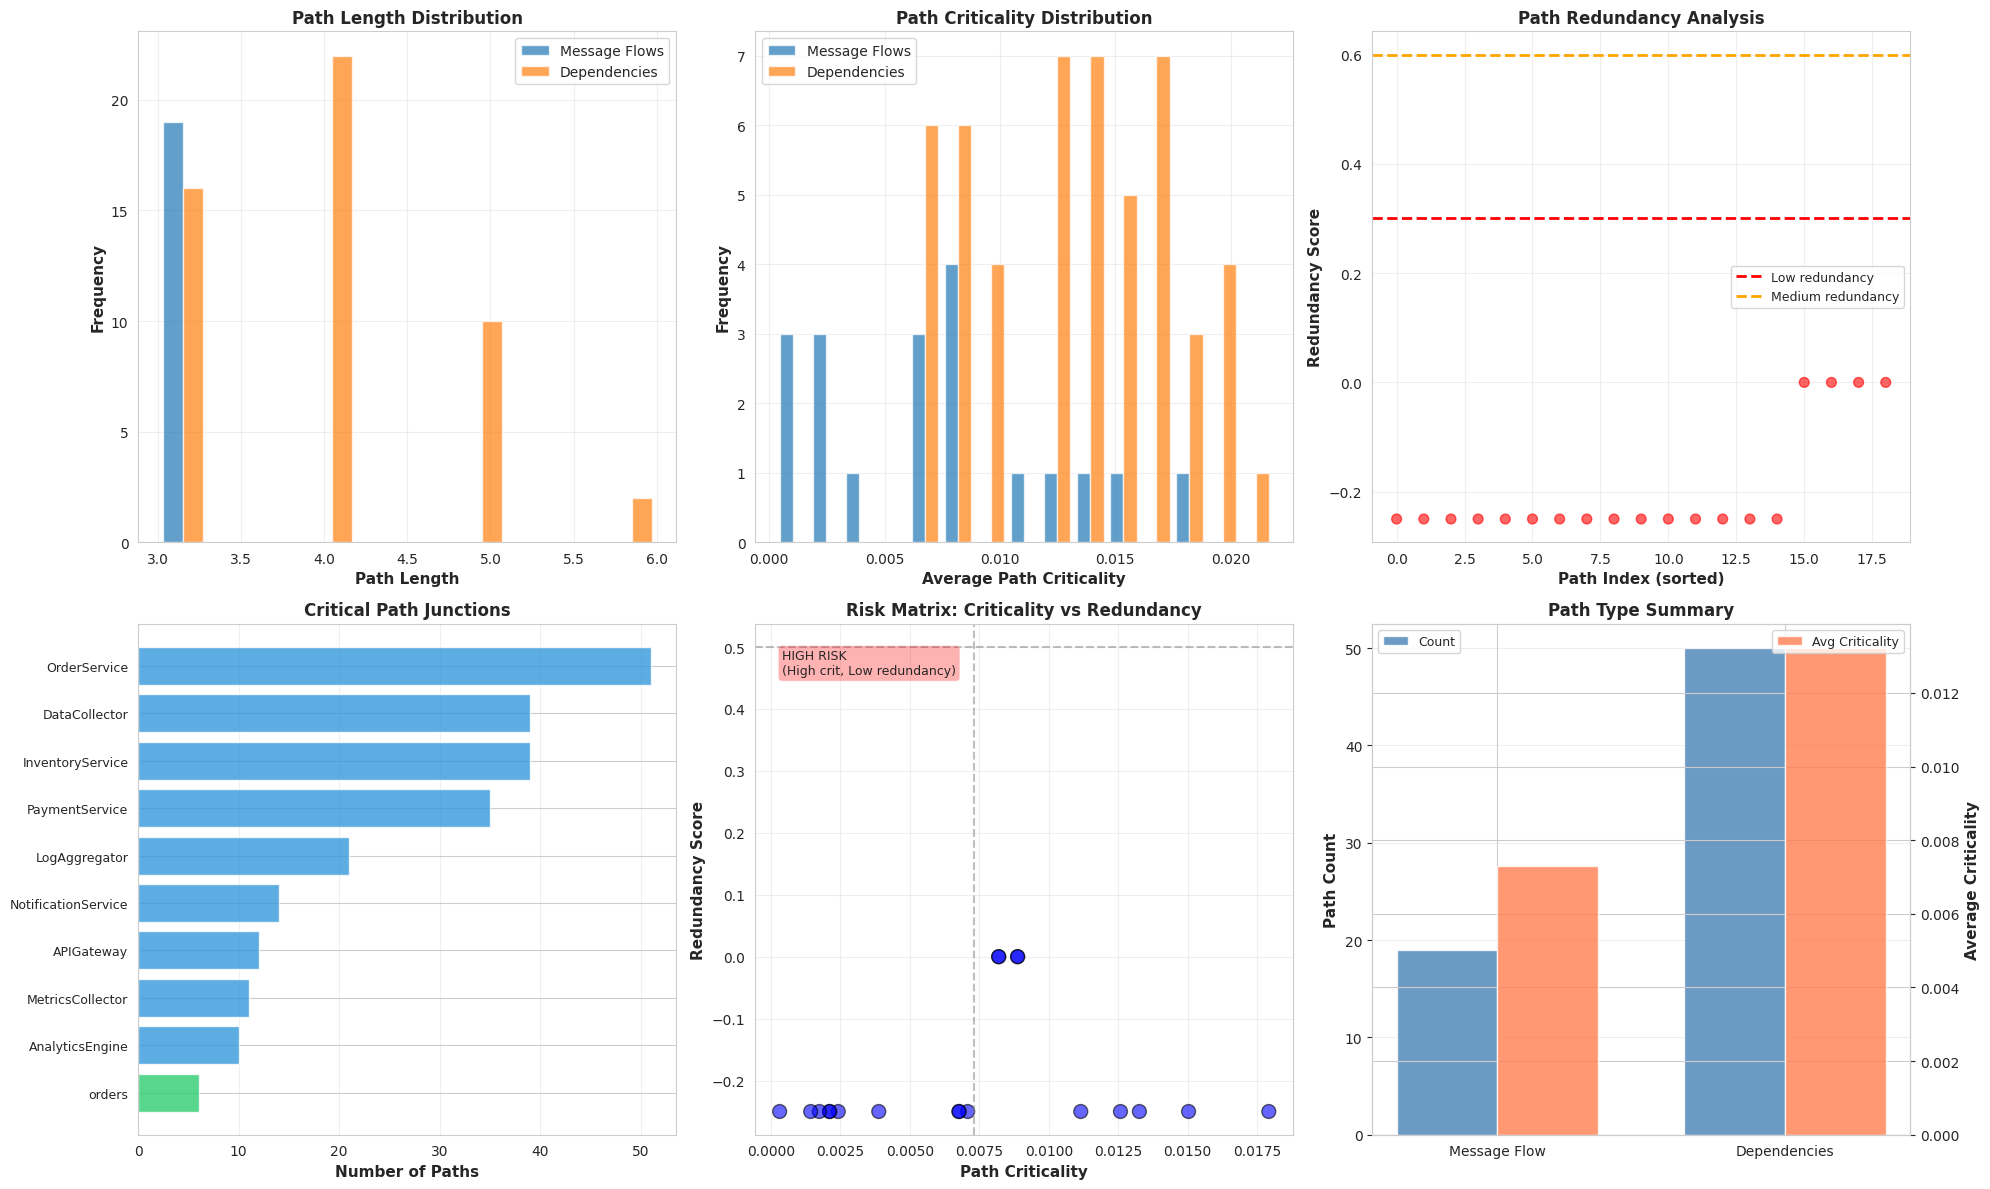


✓ Visualizations generated


In [6]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Path length distribution
ax = axes[0, 0]
msg_lengths = [p['length'] for p in message_paths]
dep_lengths = [p['length'] for p in dependency_paths]
ax.hist([msg_lengths, dep_lengths], label=['Message Flows', 'Dependencies'], bins=10, alpha=0.7)
ax.set_xlabel('Path Length', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.set_title('Path Length Distribution', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 2. Path criticality distribution
ax = axes[0, 1]
msg_crits = [p['avg_criticality'] for p in message_paths]
dep_crits = [p['avg_criticality'] for p in dependency_paths]
ax.hist([msg_crits, dep_crits], label=['Message Flows', 'Dependencies'], bins=15, alpha=0.7)
ax.set_xlabel('Average Path Criticality', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.set_title('Path Criticality Distribution', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 3. Redundancy analysis
ax = axes[0, 2]
redundancies = [p['redundancy'] for p in message_paths]
colors = ['red' if r < 0.3 else 'orange' if r < 0.6 else 'green' for r in redundancies]
ax.scatter(range(len(redundancies)), sorted(redundancies), c=colors, s=50, alpha=0.6)
ax.axhline(y=0.3, color='red', linestyle='--', linewidth=2, label='Low redundancy')
ax.axhline(y=0.6, color='orange', linestyle='--', linewidth=2, label='Medium redundancy')
ax.set_xlabel('Path Index (sorted)', fontsize=11, fontweight='bold')
ax.set_ylabel('Redundancy Score', fontsize=11, fontweight='bold')
ax.set_title('Path Redundancy Analysis', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# 4. Component frequency in paths
ax = axes[1, 0]
top_10_junctions = sorted(component_freq.items(), key=lambda x: x[1], reverse=True)[:10]
names = [G.nodes[n]['name'] for n, _ in top_10_junctions]
counts = [c for _, c in top_10_junctions]
colors_by_type = [{'Application': '#3498db', 'Topic': '#2ecc71', 
                   'Broker': '#e74c3c', 'Node': '#95a5a6'}[G.nodes[n]['type']] 
                  for n, _ in top_10_junctions]
ax.barh(range(len(names)), counts, color=colors_by_type, alpha=0.8)
ax.set_yticks(range(len(names)))
ax.set_yticklabels(names, fontsize=9)
ax.set_xlabel('Number of Paths', fontsize=11, fontweight='bold')
ax.set_title('Critical Path Junctions', fontsize=12, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

# 5. Criticality vs Redundancy scatter
ax = axes[1, 1]
crits = [p['avg_criticality'] for p in message_paths]
redunds = [p['redundancy'] for p in message_paths]
has_aps = [p['has_ap'] for p in message_paths]
colors = ['red' if ap else 'blue' for ap in has_aps]
ax.scatter(crits, redunds, c=colors, s=100, alpha=0.6, edgecolors='black')
ax.set_xlabel('Path Criticality', fontsize=11, fontweight='bold')
ax.set_ylabel('Redundancy Score', fontsize=11, fontweight='bold')
ax.set_title('Risk Matrix: Criticality vs Redundancy', fontsize=12, fontweight='bold')
ax.axvline(x=np.mean(crits), color='gray', linestyle='--', alpha=0.5)
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
ax.text(0.05, 0.95, 'HIGH RISK\n(High crit, Low redundancy)', 
        transform=ax.transAxes, fontsize=9, va='top', 
        bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))
ax.grid(True, alpha=0.3)

# 6. Path type comparison
ax = axes[1, 2]
path_stats = pd.DataFrame([
    {'Type': 'Message Flow', 'Count': len(message_paths), 
     'Avg Criticality': np.mean([p['avg_criticality'] for p in message_paths])},
    {'Type': 'Dependencies', 'Count': len(dependency_paths),
     'Avg Criticality': np.mean([p['avg_criticality'] for p in dependency_paths]) if dependency_paths else 0}
])
x = np.arange(len(path_stats))
width = 0.35
ax.bar(x - width/2, path_stats['Count'], width, label='Count', color='steelblue', alpha=0.8)
ax2 = ax.twinx()
ax2.bar(x + width/2, path_stats['Avg Criticality'], width, label='Avg Criticality', 
        color='coral', alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(path_stats['Type'], fontsize=10)
ax.set_ylabel('Path Count', fontsize=11, fontweight='bold')
ax2.set_ylabel('Average Criticality', fontsize=11, fontweight='bold')
ax.set_title('Path Type Summary', fontsize=12, fontweight='bold')
ax.legend(loc='upper left', fontsize=9)
ax2.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('critical_path_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualizations generated")

## 6. Path-Based Recommendations

In [7]:
print("\n" + "="*80)
print("PATH-BASED RECOMMENDATIONS")
print("="*80)

print("\n1. IMMEDIATE ACTIONS (High Priority)")
print("-" * 80)

# Recommendation 1: Address bottleneck paths
if bottleneck_paths:
    print("\n✓ CRITICAL: Address Bottleneck Paths")
    print(f"  → {len(bottleneck_paths)} paths go through articulation points")
    critical_aps = set()
    for p in bottleneck_paths:
        for node in p['path']:
            if node in articulation_points:
                critical_aps.add(node)
    print(f"  → Implement redundancy for: {', '.join([G.nodes[n]['name'] for n in critical_aps])}")

# Recommendation 2: Add redundancy to single-point paths
if spof_paths:
    print("\n✓ HIGH PRIORITY: Increase Path Redundancy")
    print(f"  → {len(spof_paths)} critical paths have no alternatives")
    print("  → Actions:")
    for i, p in enumerate(spof_paths[:3], 1):
        print(f"     {i}. Add alternative path for: {p['path_str']}")

# Recommendation 3: Monitor critical junctions
print("\n✓ MONITORING: Focus on Critical Junctions")
print("  → Enhanced monitoring for components in many paths:")
for node, count in top_junctions[:5]:
    print(f"     - {G.nodes[node]['name']:25s} (appears in {count} paths)")

print("\n2. MEDIUM-TERM IMPROVEMENTS")
print("-" * 80)

# Dependency chain length
if dependency_paths:
    long_chains = [p for p in dependency_paths if p['length'] >= 4]
    if long_chains:
        print("\n✓ Shorten Dependency Chains")
        print(f"  → {len(long_chains)} chains have 4+ dependencies")
        print(f"  → Consider decoupling or introducing intermediate services")

# Redundancy improvement
low_redundancy = [p for p in message_paths if p['redundancy'] < 0.5]
if low_redundancy:
    print("\n✓ Improve System Redundancy")
    print(f"  → {len(low_redundancy)} paths have <50% redundancy")
    print(f"  → Overall redundancy score: {np.mean([p['redundancy'] for p in message_paths]):.2f}")
    print(f"  → Target: >0.70 for critical paths")

print("\n3. ARCHITECTURAL IMPROVEMENTS")
print("-" * 80)

# Circuit breaker recommendations
print("\n✓ Implement Circuit Breakers")
print("  → For longest dependency chains to prevent cascading failures")
for i, p in enumerate(sorted(dependency_paths, key=lambda x: x['length'], reverse=True)[:3], 1):
    print(f"     {i}. {p['path_str']} (length: {p['length']})")

# Failover recommendations
print("\n✓ Configure Automatic Failover")
print("  → For single-point failure paths")
print("  → Implement active-passive or active-active patterns")

print("\n" + "="*80)


PATH-BASED RECOMMENDATIONS

1. IMMEDIATE ACTIONS (High Priority)
--------------------------------------------------------------------------------

✓ HIGH PRIORITY: Increase Path Redundancy
  → 19 critical paths have no alternatives
  → Actions:
     1. Add alternative path for: OrderService → orders → DataCollector
     2. Add alternative path for: DataCollector → analytics → LogAggregator
     3. Add alternative path for: InventoryService → inventory → DataCollector

✓ MONITORING: Focus on Critical Junctions
  → Enhanced monitoring for components in many paths:
     - OrderService              (appears in 51 paths)
     - DataCollector             (appears in 39 paths)
     - InventoryService          (appears in 39 paths)
     - PaymentService            (appears in 35 paths)
     - LogAggregator             (appears in 21 paths)

2. MEDIUM-TERM IMPROVEMENTS
--------------------------------------------------------------------------------

✓ Shorten Dependency Chains
  → 34 chains ha

## 7. Summary Report

In [8]:
print("\n" + "="*80)
print("COMPREHENSIVE PATH ANALYSIS SUMMARY")
print("="*80)

print("\n1. SYSTEM OVERVIEW")
print("-" * 80)
print(f"  Total Components: {G.number_of_nodes()}")
print(f"  Total Relationships: {G.number_of_edges()}")
print(f"  Articulation Points: {len(articulation_points)}")

print("\n2. PATH STATISTICS")
print("-" * 80)
print(f"  Message Flow Paths: {len(message_paths)}")
print(f"  Dependency Chains: {len(dependency_paths)}")
print(f"  Average Path Length: {np.mean([p['length'] for p in all_paths]):.2f}")
print(f"  Longest Chain: {max([p['length'] for p in dependency_paths])} hops" if dependency_paths else "  Longest Chain: N/A")

print("\n3. CRITICALITY METRICS")
print("-" * 80)
all_crits = [p['avg_criticality'] for p in all_paths]
print(f"  Average Path Criticality: {np.mean(all_crits):.4f}")
print(f"  Max Path Criticality: {np.max(all_crits):.4f}")
print(f"  Paths with High Criticality (>0.5): {len([c for c in all_crits if c > 0.5])}")

print("\n4. VULNERABILITY ASSESSMENT")
print("-" * 80)
print(f"  Bottleneck Paths (through APs): {len(bottleneck_paths)}")
print(f"  Single-Point Failure Paths: {len(spof_paths)}")
redund_scores = [p['redundancy'] for p in message_paths]
print(f"  Average Redundancy: {np.mean(redund_scores):.2f}")
print(f"  Paths with No Redundancy: {len([r for r in redund_scores if r < 0.1])}")

print("\n5. KEY FINDINGS")
print("-" * 80)

# Most critical path
most_critical_path = max(all_paths, key=lambda x: x['avg_criticality'])
print(f"  Most Critical Path:")
print(f"    → {most_critical_path['path_str']}")
print(f"    → Criticality: {most_critical_path['avg_criticality']:.4f}")
print(f"    → Type: {most_critical_path['type']}")

# Longest dependency chain
if dependency_paths:
    longest_chain = max(dependency_paths, key=lambda x: x['length'])
    print(f"\n  Longest Dependency Chain:")
    print(f"    → {longest_chain['path_str']}")
    print(f"    → Length: {longest_chain['length']} hops")
    print(f"    → Criticality: {longest_chain['avg_criticality']:.4f}")

# Most vulnerable path
if spof_paths:
    most_vulnerable = min(spof_paths, key=lambda x: x['redundancy'])
    print(f"\n  Most Vulnerable Path (lowest redundancy):")
    print(f"    → {most_vulnerable['path_str']}")
    print(f"    → Redundancy: {most_vulnerable['redundancy']:.2f}")
    print(f"    → Criticality: {most_vulnerable['avg_criticality']:.4f}")

print("\n6. RISK ASSESSMENT")
print("-" * 80)

high_risk = len([p for p in message_paths if p['avg_criticality'] > 0.6 and p['redundancy'] < 0.3])
medium_risk = len([p for p in message_paths if p['avg_criticality'] > 0.4 and p['redundancy'] < 0.5])

print(f"  HIGH RISK paths: {high_risk} (high criticality + low redundancy)")
print(f"  MEDIUM RISK paths: {medium_risk}")
print(f"  Overall System Risk: {'HIGH' if high_risk > 5 else 'MEDIUM' if high_risk > 2 else 'LOW'}")

print("\n" + "="*80)
print("END OF REPORT")
print("="*80)


COMPREHENSIVE PATH ANALYSIS SUMMARY

1. SYSTEM OVERVIEW
--------------------------------------------------------------------------------
  Total Components: 23
  Total Relationships: 76
  Articulation Points: 0

2. PATH STATISTICS
--------------------------------------------------------------------------------
  Message Flow Paths: 19
  Dependency Chains: 50
  Average Path Length: 3.70
  Longest Chain: 6 hops

3. CRITICALITY METRICS
--------------------------------------------------------------------------------
  Average Path Criticality: 0.0116
  Max Path Criticality: 0.0218
  Paths with High Criticality (>0.5): 0

4. VULNERABILITY ASSESSMENT
--------------------------------------------------------------------------------
  Bottleneck Paths (through APs): 0
  Single-Point Failure Paths: 19
  Average Redundancy: -0.20
  Paths with No Redundancy: 19

5. KEY FINDINGS
--------------------------------------------------------------------------------
  Most Critical Path:
    → LogAggregat

## Conclusion

### **Critical Path Analysis Provides:**

1. **Cascading Failure Prediction**: Identifies chains where failures propagate
2. **Redundancy Assessment**: Quantifies alternative paths and single points of failure
3. **Bottleneck Identification**: Finds paths through articulation points
4. **Dependency Chain Analysis**: Reveals long coupling sequences
5. **Actionable Recommendations**: Specific paths requiring redundancy

### **Integration with Component Analysis:**

| Analysis Type | Focus | Output |
|--------------|-------|--------|
| **Component** | Individual nodes | Which components are critical |
| **Path** | Chains & sequences | How failures cascade |
| **Combined** | System-wide | Complete risk assessment |

### **Practical Applications:**

- **Design**: Identify where to add redundancy
- **Monitoring**: Focus on critical path junctions
- **Incident Response**: Understand cascading failure potential
- **Optimization**: Shorten long dependency chains
- **Capacity Planning**: Strengthen weak links in critical paths

This multi-dimensional analysis (components + paths) provides the most comprehensive risk assessment for distributed systems!